# Potato Disease Classification

### Import all the Dependencies

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
len(dataset)

Found 2152 files belonging to 3 classes.


68

In [34]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [35]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [36]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


### Visualize some of the images from our dataset

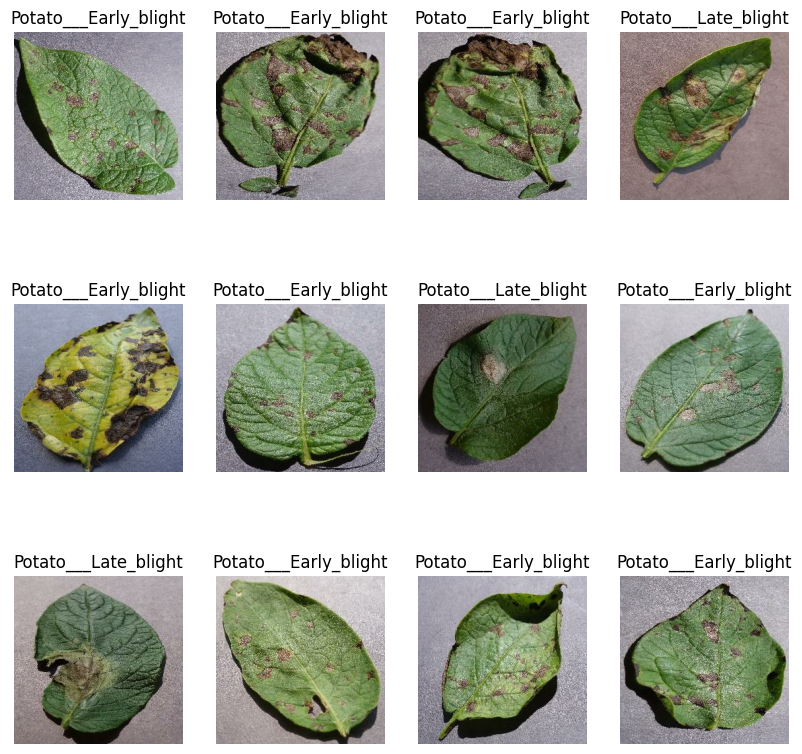

In [37]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [38]:
len(dataset)

68

In [39]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [40]:
train_ds = dataset.take(54)
len(train_ds)

54

In [41]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [42]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [43]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [44]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [45]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [46]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [47]:
len(train_ds)

54

In [48]:
len(val_ds)

6

In [49]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [51]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [52]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [53]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [54]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 37s 443ms/step - loss: 0.9023 - accuracy: 0.5064 - val_loss: 0.9140 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 15s 284ms/step - loss: 0.7076 - accuracy: 0.6968 - val_loss: 1.0163 - val_accuracy: 0.5938
Epoch 3/50
54/54 [==============================] - 15s 280ms/step - loss: 0.5196 - accuracy: 0.7841 - val_loss: 0.6026 - val_accuracy: 0.7708
Epoch 4/50
54/54 [==============================] - 15s 277ms/step - loss: 0.3763 - accuracy: 0.8455 - val_loss: 0.4481 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 17s 318ms/step - loss: 0.3420 - accuracy: 0.8640 - val_loss: 0.3823 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 15s 277ms/step - loss: 0.2619 - accuracy: 0.8953 - val_loss: 0.3587 - val_accuracy: 0.8698
Epoch 7/50
54/54 [==============================] - 15s 284ms/step - loss: 0.2361 - accuracy: 0.9115 - val_loss: 0.3438 - val_accuracy: 0.8490

In [58]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 28ms/step - loss: 0.0716 - accuracy: 0.9727


In [59]:
scores

[0.07156510651111603, 0.97265625]

In [60]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
type(history.history['loss'])

list

In [63]:
len(history.history['loss'])

50

In [64]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9023150205612183,
 0.707614004611969,
 0.5195772051811218,
 0.3762674033641815,
 0.3419973850250244]

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

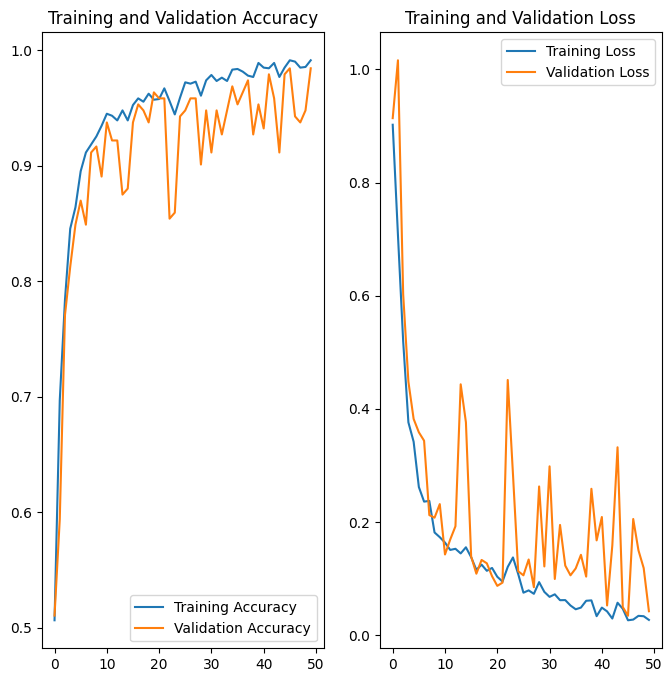

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 168ms/step
predicted label: Potato___Late_blight


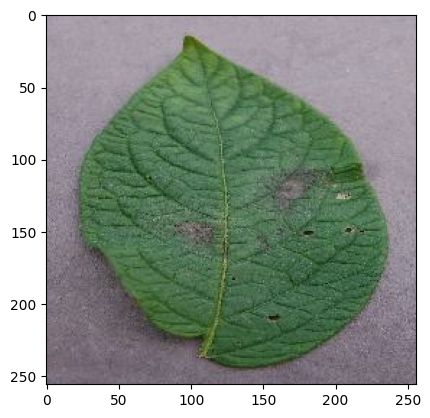

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 20ms/step


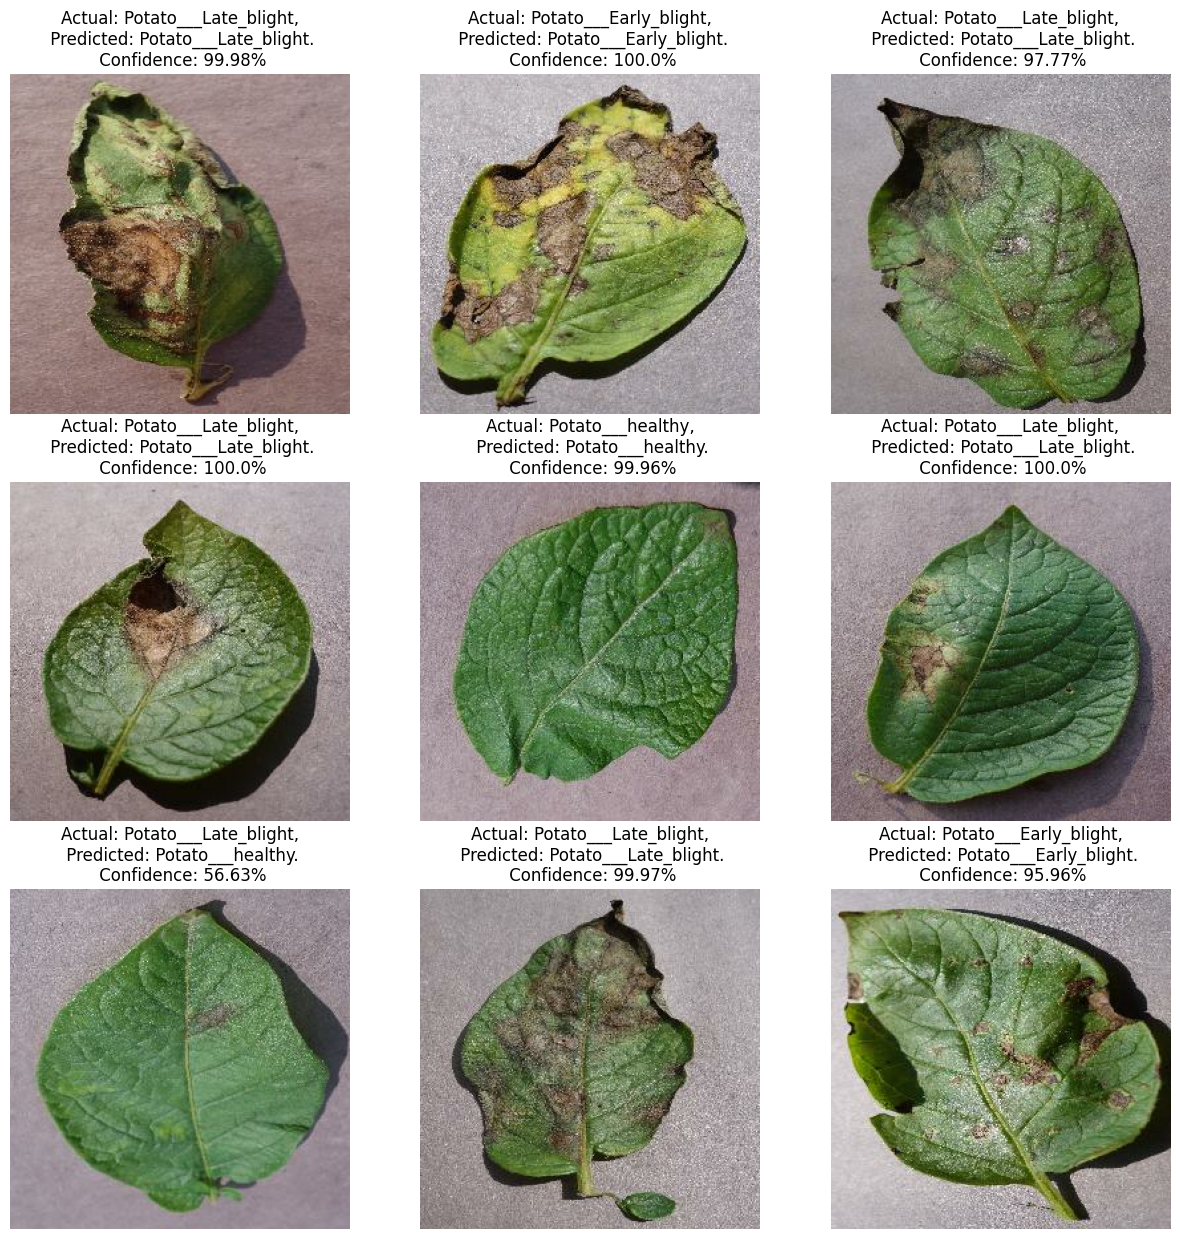

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [70]:
# prediction=[]
y_test=[]
y_predicted=[]
for images,labels in test_ds.take(32):
  for i in range(32):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        y_test.append(actual_class)
        y_predicted.append(predicted_class)
        print(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
# prediction= model.predict(test_ds)
# len(test_ds)

1/1 [==============================] - 0s 47ms/step
Actual: Potato___Late_blight,
 Predicted: Potato___Late_blight.
 Confidence: 99.98%
1/1 [==============================] - 0s 41ms/step
Actual: Potato___Early_blight,
 Predicted: Potato___Early_blight.
 Confidence: 100.0%
1/1 [==============================] - 0s 61ms/step
Actual: Potato___Early_blight,
 Predicted: Potato___Early_blight.
 Confidence: 100.0%
1/1 [==============================] - 0s 35ms/step
Actual: Potato___healthy,
 Predicted: Potato___healthy.
 Confidence: 100.0%
1/1 [==============================] - 0s 30ms/step
Actual: Potato___Late_blight,
 Predicted: Potato___Late_blight.
 Confidence: 100.0%
1/1 [==============================] - 0s 30ms/step
Actual: Potato___healthy,
 Predicted: Potato___healthy.
 Confidence: 99.96%
1/1 [==============================] - 0s 53ms/step
Actual: Potato___Early_blight,
 Predicted: Potato___Early_blight.
 Confidence: 100.0%
1/1 [==============================] - 0s 73ms/step
Actual

                       precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      1.00       110
 Potato___Late_blight       0.99      0.95      0.97       128
     Potato___healthy       0.77      0.94      0.85        18

             accuracy                           0.97       256
            macro avg       0.92      0.97      0.94       256
         weighted avg       0.98      0.97      0.97       256



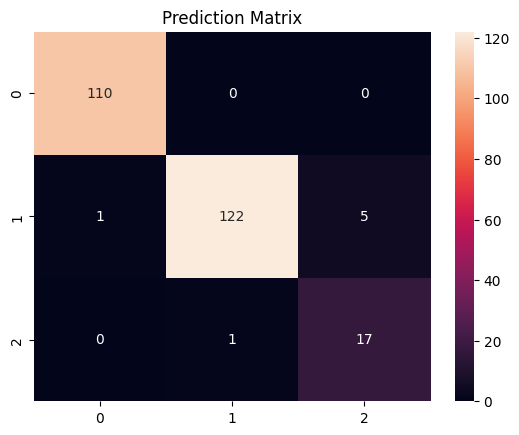

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm= confusion_matrix(y_test,y_predicted)
sns.heatmap(cm,annot=True, fmt='d').set_title("Prediction Matrix")
print(classification_report(y_test,y_predicted))